## Домашнее задание №7
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [ ]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [ ]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2022-11-27 19:37:46--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2022-11-27 19:37:46 (7.57 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [ ]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [ ]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [ ]:
next(generate_chunk())

array([[83, 62, 63, ..., 46, 56, 45],
       [83, 48, 59, ..., 61, 50, 58],
       [83, 59, 54, ..., 70,  1, 52],
       ...,
       [83,  7,  0, ..., 46, 49, 50],
       [83, 58, 53, ...,  0,  0, 46],
       [83, 56, 50, ...,  1, 62, 50]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
# your beautiful experiments here

In [ ]:
embed = nn.Embedding(10, 4)

In [ ]:
embed(torch.LongTensor([1]))

tensor([[ 0.1025, -1.7933, -1.9434, -1.0357]], grad_fn=<EmbeddingBackward0>)

In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([h_prev, x_emb], dim=-1) # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE

        h_next = torch.tanh(h_next) # YOUR CODE HERE

        assert h_next.size() == h_prev.size()

        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) # YOUR CODE

        return h_next, logits

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))

    return torch.stack(logprobs, dim=1)

In [ ]:
batch_ix = next(generate_chunk())
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

ОБУЧЕНИЕ

In [ ]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(
    predictions_logp.contiguous().view(-1, num_tokens),
    actual_next_tokens.contiguous().view(-1)
)

loss.backward()

In [ ]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

In [ ]:
char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

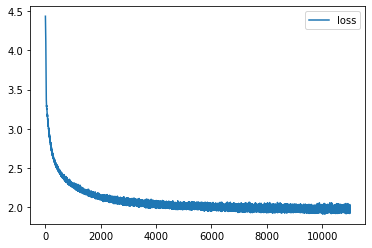

In [ ]:
MAX_LENGTH = 16

for i in range(10000):
    opt.zero_grad()

    batch_ix = next(generate_chunk())
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    # train with backprop
    loss.backward()
    opt.step()


    history.append(loss.item())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

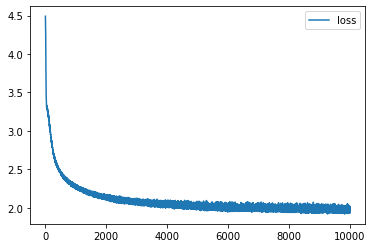

In [ ]:
#

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)


    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)


    # your code here
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [ ]:
print(generate_sample(char_rnn, seed_phrase=' мой дядя самых честных правил', max_length = 500, temperature=0.8))

<sos> мой дядя самых честных правиленнею в больцом он ждать долва бивать темно;
так в сладов ветрив,
в шумной,
гожу песеромою
заль в горки ж без юных остебкала тограм ланы,
клажней небости он к мечтосты не камями выетсенный бы межалась полчась старинный предемью,
но мы сердца глятенька ссмержно,
и онси возбыхаем,
они видил на мводь дусь он не вольдая не парнал душа на забы.
хоть в падцу нем ней и любовь я так тану голодний всех прибывлениц:



xxiii

досить
в направы спешом, куд домем песнаем я тотом


Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
# For example:

generated_phrases = [
    generate_sample(
        char_rnn,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.
    ).replace('<sos>', '')
    for _ in range(10)
]

In [ ]:
# do not change the code in the block below
# __________start of block__________

if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!